In [1]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
import seaborn as sns
sns.set_style("white")
from matplotlib.colors import LogNorm
import vcf

HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
DATAPATH="/storage/mgymrek/ssc-imputation/callstats/"
PCAFILE="/storage/s1saini/ssc-pca/pca_10.eigenvec"
ONEKGPOP="/storage/s1saini/ssc-pca/1000GenomesPopulations.csv"
SSCFAMS="/storage/s1saini/ssc-pca/ssc_family_ids.txt"
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}

OUTPATH="pdfs/"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 500 # Min number of 1000G calls to include in heterozygosity comparison
NUMSAMPLES=1916

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load info

In [2]:
locstats = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_locstats.tab"), sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)
locstats["length"] = locstats["end"]-locstats["start"]+1

In [3]:
sampstats = pd.read_fwf(os.path.join(DATAPATH, "ssc_hipstr_sampstats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

In [4]:
mend = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_mendstats.tab"), sep="\t", nrows=1000000)
mend["mend"] = mend["mend"].apply(int)
mend["chrom"] = mend["chrom"].apply(str)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
mend = mend[~mend["homref"]]
mend = pd.merge(mend, locstats[["chrom","start","end","FILTER"]], on=["chrom","start"])

# Figure 1B: Calls/sample

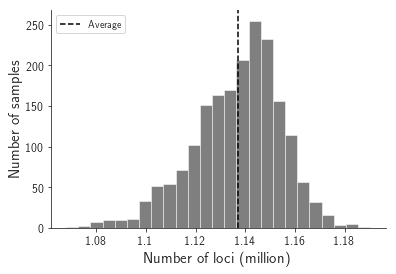

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25, alpha=0.5, label='_nolegend_');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci (million)", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([(x)/10**6 for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(x=np.mean(sampstats["numloci"]), color="black", linestyle="dashed", label="Average")
legend = ax.legend(loc='upper left')
fig.savefig(os.path.join(OUTPATH, "Figure1_LociPerSample.pdf"))

In [6]:
# Average calls/sample
np.mean(sampstats["numloci"])

1136915.9185803758

# Figure 1C: Call rate per locus

In [7]:
locstats_all = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats_all.ix[np.isnan(locstats_all["numcalls"]), "numcalls"] = 0
counts, bins = np.histogram(locstats["numcalls"], bins=25)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


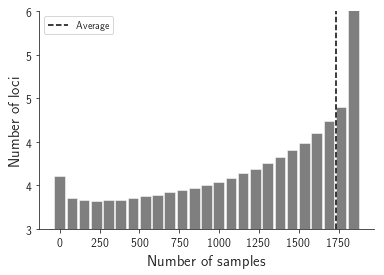

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
# Merge with hipstr reference so we get loci with 0 calls
ax.bar(bins[:-1], np.log10(counts), color="black", width=(bins[1]-bins[0])/1.15, edgecolor="white", alpha=0.5, label='_nolegend_');
ax.set_ylim(bottom=3.5, top=6);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(np.mean(locstats["numcalls"]), color="black", linestyle="dashed", label="Average")
legend = ax.legend(loc='upper left')
fig.savefig(os.path.join(OUTPATH, "Figure1_SamplesPerLocus.pdf"))

In [9]:
# Overall call rate
1-locstats_all[locstats_all["numcalls"]==0].shape[0]/locstats_all.shape[0]

0.9672751846967255

In [10]:
# Average call rate
np.mean(locstats["numcalls"])/NUMSAMPLES

0.9037484045372617

In [11]:
# Loci remaining after filtering
locstats[locstats["FILTER"]=="."].shape[0]

453671

# Figure 1D: Mendelian inheritance

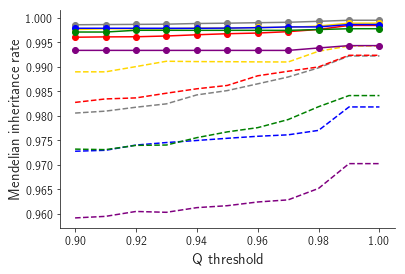

In [12]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.9, 1.1, 0.01)

mend_pass = mend[(mend["FILTER"]==".")]
mend_fail = mend[(mend["FILTER"]!=".")]

for period in range(1, 7):
    mend_scores_pass = []
    mend_scores_fail = []
    for q in scores:
        x_pass = mend_pass[(mend_pass["Q"]>=q) & (mend_pass["period"]==period)]
        if x_pass.shape[0] >= 50:
            mend_scores_pass.append(np.mean(x_pass["mend"]))
        else: mend_scores_pass.append(np.nan)
        x_fail = mend_fail[(mend_fail["Q"]>=q) & (mend_fail["period"]==period)]
        if x_fail.shape[0] >= 50:
            mend_scores_fail.append(np.mean(x_fail["mend"]))
        else: mend_scores_fail.append(np.nan)
    ax.plot(scores, mend_scores_pass, color=colors[period-1], marker="o");
    ax.plot(scores, mend_scores_fail, color=colors[period-1], linestyle="dashed");
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels(["%.2f"%(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.3f"%(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_MendelianInheritance.pdf"))

In [13]:
# Average Mend. inheritance before filtering 
np.mean(mend_fail["mend"])

0.9786428030248882

In [14]:
# Average Mend. inheritance after filtering 
np.mean(mend_pass["mend"])

0.9978261339015138

# Figure 1E: Comparison to lobSTR heterozygosities

In [15]:
lobstr = pd.read_csv(os.path.join(DATAPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: str(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]
het = pd.merge(lobstr, locstats[["chrom","start","het","FILTER"]], on=["chrom","start"])
het = het[(het["FILTER"]==".") | (het["FILTER"]=="Het")]

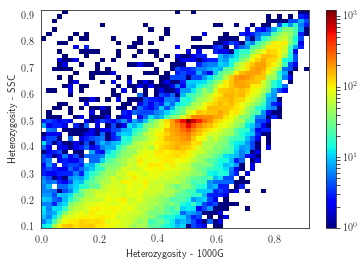

In [16]:
x = het[het["het"]>0.095]["het_lobstr"]
y = het[het["het"]>0.095]["het"]
plt.hist2d(x, y, bins=50, norm=LogNorm(), cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("Heterozygosity - 1000G")
plt.ylabel("Heterozygosity - SSC")
plt.savefig(os.path.join(OUTPATH, "Figure1_Heterozygosities.pdf"));

In [17]:
# Correlation with lobSTR heterozygosities
r, p = scipy.stats.pearsonr(het["het_lobstr"], het["het"])
print("\t".join([str(item) for item in [r, p, het.shape[0]]]))

0.955498900847542	0.0	386100


# Supplemental Figure: SSC Populations

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:62: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


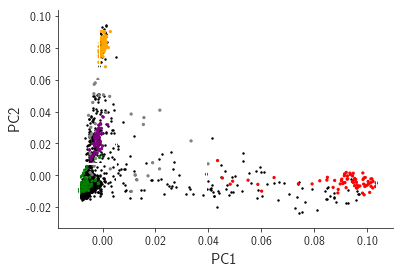

In [18]:
import matplotlib.patches as patches

# Load PCA results
pca = pd.read_csv(PCAFILE, sep=" ",
                 names=["sample","sample2"]+["pc%s"%i for i in range(1,11)])
# Load 1kg population labels
onekg = pd.read_csv(ONEKGPOP)

# Load pedigree info
ped = pd.read_csv(SSCFAMS, sep="\t", names=["id","sample"])
ped["family"] = ped["id"].apply(lambda x: x.split(".")[0])
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])

# Merge final data
data = pd.merge(pca, onekg, on="sample", how="left")
data = pd.merge(data, ped[["family","rel","sample"]], on="sample", how="left")

# Plot PCA to get boundaries
POPCOLORS = {
    "EUR": "green",
    "AFR": "red",
    "EAS": "orange",
    "SAS": "purple"
}
refdata = data[(data["Population"].apply(lambda x: str(x) != "nan"))]
refdata["color"] = refdata.apply(lambda x: POPCOLORS.get(x["Superpop"],"gray"), 1)
ssc = data[(data["Population"].apply(lambda x: str(x) == "nan"))]
ssc = pd.merge(ssc, sampstats, on=["sample"])
ssc["Superpop"] = "NA"
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ssc["pc1"], ssc["pc2"], color="black", s=2);
ax.scatter(refdata["pc1"], refdata["pc2"], color=list(refdata["color"]), s=5);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15);

# Get population boundaries
for popname in ["EAS","AFR","SAS","EUR"]:
    pop = refdata[refdata["Superpop"]==popname]
    max_pc1 = max(pop["pc1"])
    min_pc1 = min(pop["pc1"])
    max_pc2 = max(pop["pc2"])
    min_pc2 = min(pop["pc2"])
    if popname == "EUR":
        max_pc1 = 0.005
        min_pc2 = -0.02
        max_pc2 = 0.007
    if popname == "AFR":
        min_pc2 = -0.03
        max_pc2 = 0.02
    if popname == "SAS":
        max_pc2 = 0.06
        min_pc1 = -0.01
        max_pc1 = 0.005
        min_Pc2 = 0.008
    if popname == "EAS":
        min_pc2 = 0.061
        max_pc2 = 0.1
        max_pc1 = 0.01
    ssc_pop = ssc[(ssc["pc1"]>=min_pc1) & (ssc["pc1"]<=max_pc1) &
                 (ssc["pc2"]>=min_pc2) & (ssc["pc2"]<=max_pc2)]
    ssc.ix[ssc["sample"].apply(lambda x: x in ssc_pop["sample"].values),"Superpop"] = popname
    ax.add_patch(
        patches.Rectangle(
        (min_pc1, min_pc2),
        max_pc1-min_pc1,
        max_pc2-min_pc2,
        fill=False
        ))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15)
ax.set_xticklabels(["%.2f"%x for x in ax.get_xticks()], size=12);
ax.set_yticklabels(["%.2f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_PopPCA.pdf"));

In [19]:
# Get count by population group
y = ssc.groupby("Superpop", as_index=False).agg({"sample": len})
y["perc"] = y["sample"].apply(lambda x: x*1.0/sum(y["sample"]))
y

,Superpop,sample,perc
0,AFR,69,0.036013
1,EAS,39,0.020355
2,EUR,1585,0.827244
3,NA,51,0.026618
4,SAS,172,0.089770


# Tredparse calls

In [20]:
hipstr_to_tp_id = {"Expansion_ATN1/DRPLA":"DRPLA",
"Expansion_SCA2/ATXN2":"SCA2",
"Expansion_SCA8/ATXN8":"SCA8",
"Expansion_SCA3_MJD/ATXN3":"SCA3",
"Expansion_HDL2/JPH3":"HDL",
"Expansion_DM1/DMPK":"DM1",
"Expansion_SCA1/ATXN1":"SCA1",
"Expansion_SCA12/PPP2R2B":"SCA12",
"Expansion_SCA7/ATXN7":"SCA7"}

hipstr_loci = [('12', 7045880),
('12', 112036754),
('13', 70713484),
('14', 92537353),
('16', 87637889),
('19', 46273457),
('6', 16327865),
('5', 146258291),
('3', 63898361)]

def returnAFDF(locus, algo, af):
    return pd.DataFrame({'locus':[locus]*len(af), 'algorithm':[algo]*len(af), 'allele':af})

afData = pd.DataFrame()

vcf_reader = vcf.Reader(filename='/storage/s1saini/manuscript_strsnp/fig3/tredparse_calls/tredparse.output_gt.vcf.gz')
for record in vcf_reader:
    print(record.ID, len(record.REF))
    allele_list = []
    num_called = (record.num_called)
    aaf = dict(zip([len(x) for x in record.ALT],record.aaf))
    aaf[len(record.REF)] = 1-np.sum(record.aaf)
    for x in aaf:
        allele_list = allele_list + [x-len(record.REF)]*int(aaf[x]*num_called*2)
    afData = pd.concat([afData, returnAFDF(record.ID, "TredParse", allele_list)])
    

for hip_locus in hipstr_loci:
    file = '/storage/s1saini/hipstr_rerun/chr'+hip_locus[0]+'/hipstr.chr'+hip_locus[0]+'.with.1kg.filtered.vcf.gz'
    vcf_reader = vcf.Reader(filename=file)
    for record in vcf_reader.fetch(hip_locus[0], hip_locus[1]-1, hip_locus[1]+1):
        allele_list = []
        num_called = (record.num_called)
        aaf = dict(zip([len(x) for x in record.ALT],record.aaf))
        aaf[len(record.REF)] = 1-np.sum(record.aaf)
        for x in aaf:
            allele_list = allele_list + [x-len(record.REF)]*int(aaf[x]*num_called*2)
        afData = pd.concat([afData, returnAFDF(hipstr_to_tp_id[record.ID], "HipSTR", allele_list)])

DRPLA 45
SCA2 69
SCA8 45
HPE5 45
SCA3 24
HDL 42
SCA6 39
DM1 60
HD 57
SCA1 87
CCD 51
SCA17 114
EIEE1 30
SBMA 66
AR 66
FXTAS 60
FXS 60
FRAXE 45
SCA12 30
SCA7 30
SD5 45
HFG 42


In [21]:
## https://www.sciencedirect.com/science/article/pii/S0304394007010518
control_size = 307
cag_size = 3

control_sca1 = [29]*int(0.06*307) + [30]*int(0.31*307) + [31]*int(0.37*307) + [32]*int(0.09*307) + [33]*int(0.09*307) + [34]*int(0.03*307) + [35]*int(0.02*307)
control_sca2 = [22]*int(0.89*307) + [23]*int(0.09*307)
control_sca3 = [14]*int(0.24*307) + [20]*int(0.06*307) + [21]*int(0.09*307) + [22]*int(0.02*307) + [23]*int(0.26*307) + [24]*int(0.06*307) + [26]*int(0.02*307) + [27]*int(0.16*307) + [28]*int(0.04*307) 
control_sca6 = [7]*int(0.075*307) + [11]*int(0.37*307) + [12]*int(0.19*307) + [13]*int(0.32*307) + [14]*int(0.04*307)
#control_sca4 = [10]*int(0.76*307) + [11]*int(0.04*307) + [12]*int(0.14*307) + [13]*int(0.06*307)
#control_sca10 = [10]*int(0.02*307) + [11]*int(0.09*307) + [12]*int(0.27*307) + [13]*int(0.29*307) + [14]*int(0.16*307) + [15]*int(0.08*307) + [16]*int(0.05*307) + [17]*int(0.02*307) + [18]*int(0.02*307)
control_sca12 = [9]*int(0.02*307) + [10]*int(0.59*307) + [11]*int(0.01*307)  + [13]*int(0.11*307) + [14]*int(0.09*307) + [15]*int(0.15*307) + [16]*int(0.01*307) + [18]*int(0.02*307)
control_sca17 = [30]*int(0.02*307) + [33]*int(0.06*307) + [34]*int(0.15*307)  + [35]*int(0.26*307) + [36]*int(0.41*307) + [37]*int(0.06*307) + [38]*int(0.01*307)
control_sca8 = [18]*int(0.16*307) + [19]*int(0.02*307) + [21]*int(0.01*307)  + [23]*int(0.23*307) + [24]*int(0.10*307) + [25]*int(0.13*307) + [26]*int(0.11*307) + [27]*int(0.08*307)  + [28]*int(0.06*307) + [29]*int(0.04*307) + [30]*int(0.02*307) + [32]*int(0.01*307)
control_drpla = [8]*int(0.12*307) + [10]*int(0.11*307) + [11]*int(0.01*307)  + [12]*int(0.02*307) + [13]*int(0.01*307) + [14]*int(0.04*307) + [15]*int(0.37*307) + [16]*int(0.20*307)  + [17]*int(0.07*307) + [18]*int(0.01*307) + [19]*int(0.02*307) + [20]*int(0.02*307)

## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5387946/ CHINESE
control_dm1 = [5]*31+[11]*14+[12]*30+[13]*14+[14]*3+[15]*5+[16]*1+[24]*1+[27]*1

## dbgap
control_htt = [int(item.strip()) for item in open("/storage/s1saini/manuscript_strsnp/fig3/tredparse_calls/htt_control_freqs.txt").readlines()]


## https://watermark.silverchair.com/7-3-525.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAcIwggG-BgkqhkiG9w0BBwagggGvMIIBqwIBADCCAaQGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMQVRCTPBR23c3gocMAgEQgIIBdU-nNh98c-PvRwlhyJ1hcujN4Rerxl2-qN-Z_oLzrHn6I84wQh_hH8Y4mqDSALsBsGoINdN3AJlRfvnVgqrI6Jp5dOUWxytgIRn43lXiTPqM-CB66M913J9fZhcZF9XcxvW_UUsqtfKLi5GMbS3LWgKBi8aTQgn6w6zNB3nG5QfMu36TM1AUVuBCbBzx_MmE05OQj6Se_z7kxcH_lsqyotGE1znYgifTxCZ12bj2RtyuRE6ImShOWsYEDapbiXzssmTmoUPKmVUjSpbvU92yWje8Iu8abOPT-9W_Bmx-xavBnxH5lEo4HlvoL3qxtkm2KMYKbNE_YTS_03zNUO6lWa63OLyUvmlo-G-6QV5pZq967P_Z8ray2MwfoFfri21184LzL5BSXDwEB_uGYl0Fkl6hngGw0OMVANy-kscUuEh8sA4dj1YE5dTpCVEk2e2dZc0AIE7eXj30q3BQHy2USmZsX6aqdspRDjZFeWGOo1rQeEeoAa8
# Analysis of the dynamic mutation in the SCA7 gene
#shows marked parental effects on CAG repeat
#transmission
ctrl_size2 = 144
control_sca7 = [8]*(int(0.05*ctrl_size2))+[9]*(int(0.01*ctrl_size2))+\
    [10]*(int(0.55*ctrl_size2))+[11]*(int(0.15*ctrl_size2))+\
    [12]*(int(0.13*ctrl_size2))+[13]*(int(0.13*ctrl_size2))

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3880650/
control_hdl= [11]*int(0.03*352) + [14]*int(0.53*352) + [15]*int(0.05*352) + [16]*int(0.28*352) + [17]*int(0.07*352) + [18]*int(0.01*352)

sca1_length = 87
sca2_length = 69
sca3_length = 24+18 # adding imperfect region next to it
sca6_length = 39
#sca4_length = 0
#sca10_length = 0
sca12_length = 30
sca17_length = 114
sca8_length = 78 #45 changing since also has "TAC" repeat next to it
drpla_length = 45
dm1_length = 60
#htt_length = 0
hdl_length = 42
htt_length = 57
sca7_length = 30

afData = pd.concat([afData, returnAFDF("SCA1", "Control", [x*3-sca1_length for x in control_sca1])])
afData = pd.concat([afData, returnAFDF("SCA2", "Control", [x*3-sca2_length for x in control_sca2])])
afData = pd.concat([afData, returnAFDF("SCA3", "Control", [x*3-sca3_length for x in control_sca3])])
afData = pd.concat([afData, returnAFDF("SCA6", "Control", [x*3-sca6_length for x in control_sca6])])
afData = pd.concat([afData, returnAFDF("SCA12", "Control", [x*3-sca12_length for x in control_sca12])])
afData = pd.concat([afData, returnAFDF("SCA17", "Control", [x*3-sca17_length for x in control_sca17])])
afData = pd.concat([afData, returnAFDF("SCA8", "Control", [x*3-sca8_length for x in control_sca8])])
afData = pd.concat([afData, returnAFDF("DRPLA", "Control", [x*3-drpla_length for x in control_drpla])])
afData = pd.concat([afData, returnAFDF("DM1", "Control", [x*3-dm1_length for x in control_dm1])])
afData = pd.concat([afData, returnAFDF("HDL", "Control", [x*3-hdl_length for x in control_hdl])])
afData = pd.concat([afData, returnAFDF("HD", "Control", [x*3-htt_length for x in control_htt])])
afData = pd.concat([afData, returnAFDF("SCA7", "Control", [x*3-sca7_length for x in control_sca7])])

HD 17.0 18.0 Ttest_indResult(statistic=-0.04357719567278365, pvalue=0.9652436031033031)
SCA1 30.0 31.0 Ttest_indResult(statistic=-7.162193345371833, pvalue=9.533985514447339e-13)
SCA17 37.0 35.0 Ttest_indResult(statistic=8.233534034612386, pvalue=2.52253196225264e-16)
SCA2 22.0 22.0 Ttest_indResult(statistic=1.344936697552033, pvalue=0.17872052402034058)
DRPLA 15.0 15.0 Ttest_indResult(statistic=-2.1273713583170375, pvalue=0.03345645065291013)
SCA8 25.0 24.0 Ttest_indResult(statistic=4.572857284527722, pvalue=4.9601204229938e-06)
SCA3 23.0 23.0 Ttest_indResult(statistic=2.3742588637569195, pvalue=0.017632560996789663)
DM1 11.0 12.0 Ttest_indResult(statistic=0.6793745354097702, pvalue=0.49694064111705294)
SCA6 11.0 12.0 Ttest_indResult(statistic=-2.5831264562647713, pvalue=0.009828450448721077)
SCA7 11.0 10.0 Ttest_indResult(statistic=3.2820884163210318, pvalue=0.0010503908534191843)
SCA12 13.0 10.0 Ttest_indResult(statistic=4.763949394132788, pvalue=1.99494946890663e-06)
HDL 16.0 14.0 

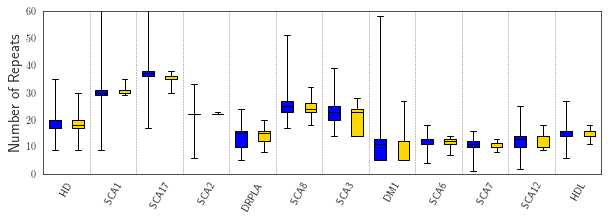

In [22]:
#

#loci = set(afData["locus"])
loci = ["HD", "SCA1","SCA17","SCA2","DRPLA","SCA8","SCA3","DM1","SCA6","SCA7","SCA12","HDL"]
ref_len = {
    "HD": htt_length,
    "SCA1": sca1_length,
    "SCA17": sca17_length,
    "SCA2": sca2_length,
    "DRPLA": drpla_length,
    "SCA8": sca8_length,
    "SCA3": sca3_length,
    "DM1": dm1_length,
    "SCA6": sca6_length,
    "SCA7": sca7_length,
    "SCA12": sca12_length,
    "HDL": hdl_length
}
data = []
labels = []
for locus in loci:
    tp = []
    ct = []
    for algorithm in "TredParse","Control":
        x = (np.array(list(afData[(afData["algorithm"]==algorithm) & (afData["locus"]==locus)]["allele"]))+ref_len[locus])/3
        data.append(x)
        if algorithm == "TredParse":
            tp = x
            labels.append(locus)
        else:
            ct = x
            labels.append("")
    print("%s %s %s %s"%(locus, np.median(tp), np.median(ct), scipy.stats.ttest_ind(tp, ct)))
    
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
bplot = ax.boxplot(data, whis="range", patch_artist=True, medianprops={"color":"black"});
ax.set_ylim(bottom=0, top=60);

colors = ["blue","gold"]*len(loci)
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
ax.set_xticks(np.arange(1.5, len(loci)*2+0.5, 2));
ax.set_xticklabels(loci, rotation=60);
for i in np.arange(2.5, len(loci)*2, 2): ax.axvline(x=i, color="gray", linestyle="dashed", linewidth=0.5)
ax.set_ylabel("Number of Repeats", size=15);
fig.savefig(os.path.join("pdfs","Figure1_TP.pdf"))
# Need to fix
# SCA8 - had other repeat next to it that was counted
# SCA3
# SCA7 no controls

# Supplemental Figure: Length bias

In [23]:
reflen = range(10, 100, 1)
diffs = []
percs = []
for i in range(len(reflen)-1):
    lb = reflen[i]
    ub = reflen[i+1]
    x = locstats[(locstats["length"]>=lb) & (locstats["length"]<ub)]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else:
        diffs.append(sum(x.apply(lambda x: x["mean_allele"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<ub].shape[0]*1.0/locstats.shape[0])

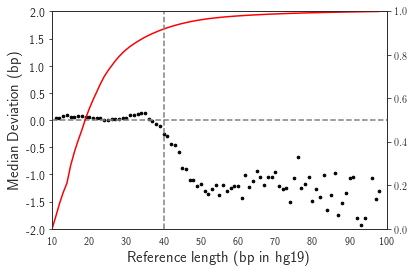

In [24]:
xmax = 100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen[:-1], diffs, color="black", s=7);
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Median Deviation (bp)", size=15)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=10, right=xmax)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")

ax2 = ax.twinx()
ax2.plot(reflen[:-1], percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=xmax)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax2.axvline(x=40, linestyle="dashed", color="gray")
fig.savefig(os.path.join(OUTPATH, "SuppFig_LengthBias.pdf"));

# Capillary data

In [25]:
def GetConcordance(x):
    if x["gral1"] < x["gral2"]:
        g1, g2 = x["gral1"], x["gral2"]
    else: g1, g2 = x["gral2"], x["gral1"]
    if x["imal1"] < x["imal2"]:
        i1, i2 = x["imal1"], x["imal2"]
    else: i1, i2 = x["imal2"], x["imal1"]
    if "." in [g1, g2, i1, i2]: return np.nan
    g1 = int(g1); g2=int(g2); i1=int(i1); i2=int(i2)
    g1 = g1 + x["offset"]
    g2 = g2 + x["offset"]
    if g1 == i1 and g2 == i2: return 1
    elif g1 in [i1, i2] or g2 in [i1, i2]: return 0.5
    else: return 0
    
def GetConcordance2(x):
    diff1 = abs(x["gral1"]-x["gral2"])
    diff2 = abs(x["imal1"]-x["imal2"])
    return int(diff1==diff2)

In [26]:
data = pd.read_csv("capillary_vs_imputed_calls.csv")
data["offset"] = 0
data["conc"] = data.apply(GetConcordance, 1)
data = data[~np.isnan(data["conc"])]

In [27]:
MINSAMPLES = 50

# restrict to repeats analyzed in lobstr paper
usestrs = pd.read_csv("marshfield_marker_corrections.tab", sep="\t", names=["chrom","start","end","name2","offset_lob"])
pemb = pd.read_csv("pemberton_sorted.tab", sep="\t", names=["name","name2"])
usestrs = pd.merge(usestrs, pemb, on=["name2"])

# Restrict to loci with at least 50 samples 
names = []
calls = []
for locus in set(usestrs["name"]):
    names.append(locus)
    calls.append(data[(data["name"]==locus) & (data["gral1"]!=".")].shape[0])
callrate = pd.DataFrame({"name": names, "calls": calls})
usestrs = pd.merge(usestrs, callrate, on=["name"])
usestrs = usestrs[usestrs["calls"]>=MINSAMPLES]
data = pd.merge(usestrs, data, on=["name"])

In [28]:
# Restrict to European samples
ONEKGPOP="1000GenomesPopulations.csv"
onekg = pd.read_csv(ONEKGPOP)
eur_samples = list(onekg[onekg["Superpop"]=="EUR"]["sample"])
data = data[data["sample"].apply(lambda x: x in eur_samples)]

In [29]:
offsets = {}
markers = set(data["name"])
for col in ["gral1","gral2","imal1","imal2"]:
    data[col] = data[col].apply(int)
for marker in markers:
    x = data[data["name"]==marker].copy()
    x["err1"] = -1*(x["gral1"]-x["imal1"])
    x["err2"] = -1*(x["gral1"]-x["imal2"])
    x["err3"] = -1*(x["gral2"]-x["imal1"])
    x["err4"] = -1*(x["gral2"]-x["imal2"])
    possible_offsets = set(list(x["err1"])+list(x["err2"])+ list(x["err3"]) + list(x["err4"]))
    best_offset = 0
    best_conc = 0
    for po in possible_offsets:
        x["offset"] = po
        x["conc"] = x.apply(GetConcordance, 1)
        m = np.mean(x["conc"])
        if m > best_conc:
            best_conc = m
            best_offset = po
    offsets[marker] = best_offset

In [30]:
data["offset"] = data.apply(lambda x: offsets.get(x["name"], 0), 1)
data["conc"] = data.apply(GetConcordance, 1)

print(np.mean(data["conc"]))

0.7685219773378159


In [31]:
markers = list(set(data["name"]))
conc = []
for marker in markers:
    x = data[data["name"]==marker]
    conc.append(np.mean(x["conc"]))
d = pd.DataFrame({"name": markers, "conc": conc})
d = d.sort_values("conc")

(0.9622866790874177, 0.0)


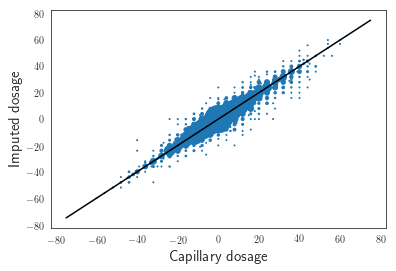

In [32]:
# Bubble plot
data["dosage1"] = data["gral1"]+data["gral2"]+data["offset"]*2
data["dosage2"] = data["imal1"]+data["imal2"]

print(scipy.stats.pearsonr(data["dosage1"], data["dosage2"]))

bubble = data.groupby(["dosage1","dosage2"], as_index=False).agg({"conc": len})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubble["dosage1"], bubble["dosage2"], s=bubble["conc"])
ax.plot([-75,75],[-75,75], color="black")
ax.set_xlabel("Capillary dosage", size=15)
ax.set_ylabel("Imputed dosage", size=15);

## Per-locus comparison with SSC LOO

In [33]:
DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
sscloo["loo_r2"] = sscloo["loo_r"]**2
sscloo["wgs_eur_r2"] = sscloo["wgs_eur_r"]**2
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","pos"]).drop_duplicates(subset=['pos'])
position_to_id = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/position_to_id/ALL.position_to_id.txt", names=["pos", "str"], delim_whitespace=True)
expected_concordance = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/expected_concordance/ALL.exp_concord.txt", names=["pos", "exp_concord"], delim_whitespace=True)
expected_concordance = pd.merge(expected_concordance, position_to_id, on="pos", how="inner")
sscloo = pd.merge(sscloo, expected_concordance, on="str", how="inner")
sscloo = pd.merge(sscloo[["str","loo_concordance","wgs_eur_concordance","wgs_eur_r2", "loo_r2","exp_concord"]], id_start, on=["str"])

In [34]:
loci = list(set(data["name"]))
conc = []
conc2 = []
r2 = []

for l in loci:
    x = data[data["name"]==l]
    conc.append(np.mean(x.apply(GetConcordance, 1)))
    conc2.append(np.mean(x.apply(GetConcordance2, 1)))
    r2.append(scipy.stats.pearsonr(x["dosage1"], x["dosage2"])[0]**2)
capdata = pd.DataFrame({"str": loci, "cap_conc": conc, "cap_r2": r2, "cap_conc2": conc2})

(0.8303417260396155, 1.050336256812244e-53)
206
0.7688229352565842
0.7688229352565842
0.36764582287683034


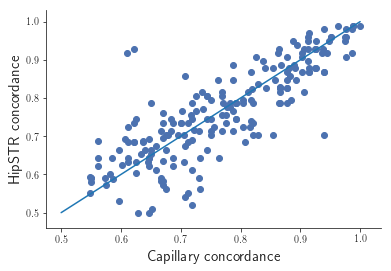

In [35]:
comp = pd.merge(capdata, sscloo, on=["str"])

true_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
exp_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(comp["cap_conc"], comp["wgs_eur_concordance"], color=true_color)
#ax.scatter(comp["cap_conc"], comp["exp_concord"], color=exp_color)
ax.plot([0.5, 1], [0.5,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Capillary concordance", size=15)
ax.set_ylabel("HipSTR concordance", size=15)
fig.savefig("Figure2_Capillary.pdf")
print(scipy.stats.pearsonr(comp["cap_conc"], comp["wgs_eur_concordance"]))
print(comp.shape[0])
print(np.mean(comp["cap_conc"]))
print(np.mean(comp["cap_conc"]))
print(np.mean(comp["exp_concord"]))

# 10X data for NA12878

In [36]:
DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"

def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, label="_nolegend_"):
    ax = ax if ax is not None else plt.gca()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    base_line, = ax.plot(x, y, color=color, label=label)
    if color is None:
        color = base_line.get_color()
    ax.fill_between(x, ymax, ymin, facecolor=color, alpha=alpha_fill)

def GetError(x, num):
    snp1 = x["snppanel"].split("|")
    snp2 = x["snp10x"].split("|")
    str1 = x["strpanel"].split("|")
    str2 = x["str10x"].split("|")
    str1 = [int(item) for item in str1]
    str2 = [int(item) for item in str2]
    if snp1[0] == snp2[0]:
        if num == 1: return str1[0]-str2[0]
        else: return str1[1]-str2[1]
    else: 
        if num == 1: return str1[1]-str2[0]
        else: return str1[0]-str2[1]
        
def Concordant(gt1, gt2):
    gt1 = gt1.split("|")
    gt2 = gt2.split("|")
    if gt1[0] == gt2[0] and gt1[1] == gt2[1]: return True
    elif gt1[1] == gt2[0] and gt1[0] == gt2[1]: return True
    else: return False
    
def IsHet(gt):
    gt = gt.split("|")
    return gt[0] != gt[1]

# Get phase info
def GetPhase(x):
    snp1 = x["snppanel"].split("|")
    snp2 = x["snp10x"].split("|")
    str1 = x["strpanel"].split("|")
    str2 = x["str10x"].split("|")
    if snp1[0] == snp2[0]:
        return str1[0]==str2[0] and str1[1]==str2[1]
    else: return str1[1]==str2[0] and str1[0]==str2[1]

In [37]:
tenx = pd.read_csv("/storage/mgymrek/ssc-imputation/na12878-10x/na12878_panel_vs_10x.tab", sep="\t")
tenx["locus"] = tenx.apply(lambda x: str(x["chrom"])+":"+str(x["strpos"]), 1)

sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","locus"]).drop_duplicates(subset=['locus'])
sscloo = pd.merge(sscloo, id_start, on=["str"])

tenx = pd.merge(tenx, sscloo[["locus","loo_concordance"]], on=["locus"])

tenx["str.conc"] = tenx.apply(lambda x: Concordant(x["strpanel"], x["str10x"]), 1)
tenx["snp.conc"] = tenx.apply(lambda x: Concordant(x["snppanel"], x["snp10x"]), 1)
tenx["str.het"] = tenx.apply(lambda x: IsHet(x["str10x"]), 1)

print("Before filtering, have %s strs"%tenx.shape[0])
tenx_filtered = tenx[tenx["snp.conc"]]
print("After filtering for discordant SNP, have %s strs"%tenx_filtered.shape[0])

# Get size of errors
tenx_filtered["error1"] = tenx_filtered.apply(lambda x: GetError(x, 1), 1)
tenx_filtered["error2"] = tenx_filtered.apply(lambda x: GetError(x, 2), 1)

# Get phase
tenx_filtered["phase.correct"] = tenx_filtered.apply(lambda x: GetPhase(x), 1)

Before filtering, have 118353 strs
After filtering for discordant SNP, have 116764 strs


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
# Stats on STR genotype concordance
print("Overall STR genotype concordance %s"%np.mean(tenx_filtered["str.conc"]))

# Stats on per-allele concordance
print("Allele concordance %s"%np.mean(list(tenx_filtered["error1"]==0)+list(tenx_filtered["error2"]==0)))
# Of het STRs called correctly, how many had correct phase
x = np.mean(tenx_filtered[tenx_filtered["str.conc"] & tenx_filtered["str.het"]]["phase.correct"])
print("How many phased correctly %s"%x)

Overall STR genotype concordance 0.9270237401938953
Allele concordance 0.9604415744578808
How many phased correctly 0.9975461179154917


In [39]:
print("number of calls compared: %s"%tenx_filtered.shape[0])
print("number of hets: %s"%tenx_filtered[tenx_filtered["str.het"]].shape[0])
print("number of hets correct: %s"%tenx_filtered[(tenx_filtered["str.het"]) & (tenx_filtered["str.conc"])].shape[0])

number of calls compared: 116764
number of hets: 53243
number of hets correct: 46457


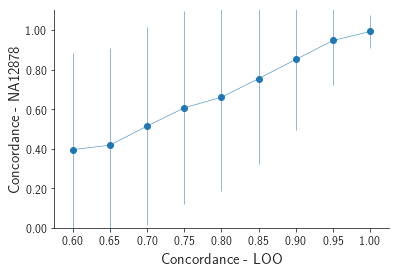

In [40]:
# Stratify by LOO concordance
true_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
CONCBIN=0.05

means = []
sds = []
nums = []
cbs_plot = []
cbs = [round(item, 2) for item in np.arange(0.4, 1+CONCBIN, CONCBIN)]
for cb in cbs:
    x = np.array(tenx_filtered[(tenx_filtered["loo_concordance"]>=cb) & (tenx_filtered["loo_concordance"]<cb+CONCBIN)]["str.conc"])
    if len(x)>=100:
        means.append(np.mean(x))
        sds.append(np.sqrt(np.var(x)))
        cbs_plot.append(cb)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(cbs_plot, means, yerr=sds, marker="o", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Concordance - LOO", size=15)
ax.set_ylabel("Concordance - NA12878", size=15)
ax.set_xlim(left=cbs_plot[0]-CONCBIN/2, right=1+CONCBIN/2)
ax.set_ylim(bottom=0, top=1.1)
ax.set_xticklabels(["%.2f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig("pdfs/na12878_10x_conc.pdf")

In [41]:
# Is concordance correlated with distance to nearest het SNP? moderately
import scipy.stats
tenx_filtered["snp.dist"] = tenx_filtered.apply(lambda x: abs(x["snppos"]-x["strpos"]), 1)
tenx_filtered2 = tenx_filtered[tenx_filtered["snp.dist"]<=50000]
scipy.stats.pearsonr(tenx_filtered2["snp.dist"], tenx_filtered2["str.conc"])

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(-0.04077860031986612, 3.88275189168836e-44)

In [42]:
# Look at CODIS + other markers
codis_markers = ["5:149455884","13:82722160","18:60948895", \
                 "19:30417140","3:45582231","5:123111245", \
                "7:83789542","8:125907107","4:155508888", \
                "15:97374244","11:2192318","2:1493425","22:46659670"]
tenx_filtered[tenx_filtered["locus"].apply(lambda x: x in codis_markers)]

,chrom,strpos,snppos,strpanel,str10x,snppanel,snp10x,locus,loo_concordance,str.conc,snp.conc,str.het,error1,error2,phase.correct,snp.dist
57792,7,83789542,83789601,-20|-16,-20|-12,1|0,1|0,7:83789542,0.708768,False,True,True,0,-4,False,59
88941,13,82722160,82722134,0|4,0|4,0|1,0|1,13:82722160,0.685804,True,True,True,0,0,True,26
118161,22,46659670,46659579,0|4,0|4,0|1,0|1,22:46659670,0.994781,True,True,True,0,0,True,91


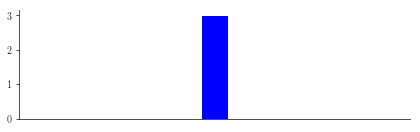

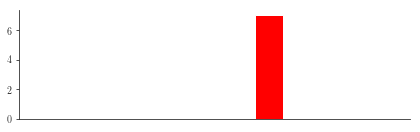

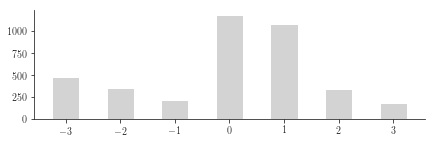

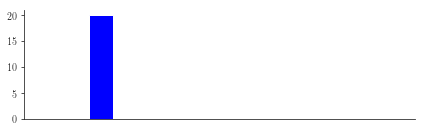

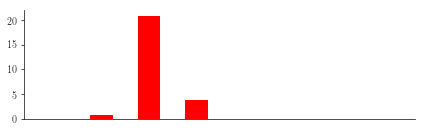

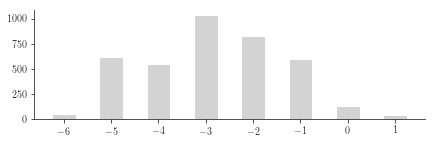

In [43]:
# Plot examples for panel
width=0.5

loci = [("13:82722160", 4), ("7:83789542", 4)]
for locus, period in loci:
    chrom, start = locus.split(":")
    lines = open("%s_%s_panel.txt"%(chrom, start)).readlines()
    alleles1 = [int(item)/period for item in lines[0].strip().split()]
    alleles2 = [int(item)/period for item in lines[1].strip().split()]
    allelesALL = [int(item)/period for item in lines[2].strip().split()]

    vals = [item for item in sorted(list(set(allelesALL))) if allelesALL.count(item)>=10]
    counts1 = [alleles1.count(item) for item in vals]
    counts2 = [alleles2.count(item) for item in vals]
    countsALL = [allelesALL.count(item) for item in vals]
    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, counts1, color="blue", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    fig.savefig("pdfs/%s_%s_hap1.pdf"%(chrom, start))
    
    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, counts2, color="red", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    fig.savefig("pdfs/%s_%s_hap2.pdf"%(chrom, start))

    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, countsALL, color="lightgray", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(vals)
    fig.savefig("pdfs/%s_%s_all.pdf"%(chrom, start))
    #ax.bar([item+width for item in vals], counts2, width=width, color="blue")